In [39]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(RColorBrewer)
library(GGally)
library(broom)
library(readxl)
library(httr)
packageVersion("readxl")
options(repr.matrix.max.rows = 6)

[1] ‘1.4.0’

# Classifying the Knowledge Level of a Student

## Introduction
Accumulation of knowledge is an important part of education. However, one might wonder what would be the best way to gain knowledge? And what may affect one's knowledge level on a particular subject?

### Our question
How can we classify the knowledge level of a student with their study time, degree of repetition, and exam performace? Is there a more accurate way to classify the knowledge level with other parameters?

### Dataset
For our project, we will be using the User Knowledge Modeling Data Set, retrieved from https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling#. 

This data set contains data about the knowledge level of students on the subject of electrical DC machines, along with information about each students' study time, degree of repetition on the subject, study time on subjects related to this subject, the exam performance for subjects related to this subject, and exam performace for this subject. 

The data can be downloaded from going to the website and clicking "Data Folder". The data was downloaded, transformed into a csv file, and uploaded into the data folder for this project.

## Methods & Results

Intuitively, study time, degree of repetition, and exam performance seem to be the most important measures for knowledge level, as they are all directly related to the subject tested. Therefore, we expect there to be a positive correlation between these parameters and knowledge level. This positive correlation may lead to these parameters being more accurate in analysis, but it is not guaranteed. We will also attempt to find scientifically the best parameters to classify knowledge level. After reading in the data and cleaning it, our first goal is to explore our dataset to preliminarily observe if our intution can be justified.

### Reading in file from the web into R

The file is found in:
https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls.

In this excel file, there are multiple sheets. We separate the training data in the second sheet into the object training_data and the testing data in the third sheet into the object testing_data respectively with the code below:

In [40]:
url1<- 'https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls'
p1f <- tempfile()
download.file(url1, p1f, mode="wb")

GET(url1, write_disk(tf <- tempfile(fileext = ".xls")))
training_data <- read_excel(tf, 2L)
testing_data <- read_excel(tf, 3L)


# This code reads the second and third sheet of the excel file into the training data and testing data objects respectively. The idea of reading the data in this fashion was found from stack overflow:
# https://stackoverflow.com/questions/41368628/read-excel-file-from-a-url-using-the-readxl-package

training_data <- select(training_data, STG:UNS)
testing_data <- select(testing_data,  STG:UNS)

# The code above selects the rows used in data analysis and removes excess meta information

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls]
  Date: 2022-12-04 23:51
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 57.9 kB
<ON DISK>  /tmp/RtmpP0JxQb/file42f1a67e3.xlsNULL

New names:
• `` -> `...7`
• `` -> `...8`
New names:
• `` -> `...7`
• `` -> `...8`


### Cleaning and wrangling into tidy format

Here is what the first 5 rows of our training and testing data look like:

In [41]:
slice(training_data, 1:5)
slice(testing_data, 1:5)

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


It is unclear what the column names mean. Furthermore, the "very_low" value in the UNS column in the training data is different from the "Very Low" value in the testing data. From the source website, here is what the column labels mean: 

For each student,

STG: The degree of study time for subject

SCG: The degree of repetition for subject materials

STR: The degree of study time for related subjects

LPR: The exam performance for related subjects

PEG: The exam performance for subject

UNS: The knowledge level

Lets rename the columns for both sets of data to have better understanding:

In [42]:
training_data <- rename(training_data, 
                        direct_study_time = STG,
                        direct_repetition_degree = SCG,
                        related_study_time = STR,
                        related_exam_performance = LPR,
                        direct_exam_performance = PEG,
                        direct_knowledge_level = UNS) %>%
                        mutate(direct_knowledge_level = replace(direct_knowledge_level, direct_knowledge_level == "very_low", "Very Low"))

# The code "mutate(direct_knowledge_level = r..." renames all values of "very_low" in direct_knoweldge_level column  
# to "Very Low". This process is needed, as it is how the values are named in the testing data, and so that there is
# a standard which is needed when determining accuracy later on. The idea of the code was gotten from:
# https://statisticsglobe.com/r-replace-value-of-data-frame-variable-dplyr-package

testing_data <- rename(testing_data, 
                        direct_study_time = STG,
                        direct_repetition_degree = SCG,
                        related_study_time = STR,
                        related_exam_performance = LPR,
                        direct_exam_performance = PEG,
                        direct_knowledge_level = UNS) 

Let's also turn direct knowledge level into a factor instead of as characters, as it will be convenient for classifcication later on:

In [43]:
training_data <- mutate(training_data, direct_knowledge_level = as_factor(direct_knowledge_level))
testing_data <- mutate(testing_data, direct_knowledge_level = as_factor(direct_knowledge_level))

In [44]:
slice(training_data, 1:5)
slice(testing_data, 1:5)

direct_study_time,direct_repetition_degree,related_study_time,related_exam_performance,direct_exam_performance,direct_knowledge_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


direct_study_time,direct_repetition_degree,related_study_time,related_exam_performance,direct_exam_performance,direct_knowledge_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
0.20,0.20,0.68,0.67,0.85,High
0.22,0.22,0.90,0.30,0.90,High


As we can see from our new table above, each row is a single observation, each column is a single variable, and each value is a single cell. Furthermore, our columns and variables are more understandable and clear. Therefore, our data is tidy.

### Exploratory tables
Lets explore our training data to see if the values we chose to conduct classification seem justified.
#### Mean of each numerical column

In [45]:
mean_values <- training_data %>%
  select(-direct_knowledge_level) %>%
  map_df(mean)
mean_values

direct_study_time,direct_repetition_degree,related_study_time,related_exam_performance,direct_exam_performance
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3711473,0.3556744,0.4680039,0.4327132,0.4585388


The means of each variable shows their average values, giving us insight in what the values in the table table may generally look like.

#### Number of each label in direct knowledge level


In [46]:
number_of_each_descriptor <- training_data %>%
  select(direct_knowledge_level) %>%
  group_by(direct_knowledge_level) %>%
  summarize(n = n())
number_of_each_descriptor

direct_knowledge_level,n
<fct>,<int>
Very Low,24
High,63
Low,83
Middle,88


From this table, we can see the number of each classifications there are. As we will classify our data based on descriptors, an imbalance of number of descriptors in our data may create inaccuracies. The table shows that the descriptor "very_low" has significantly less observations than the other descriptors. Therefore, during k-nn classification the other descriptors will naturally be chosen more. This may shift the preference of our k values to be smaller or decrease our analysis accuracy overall.

#### Mean of each numerical column when grouped by knowledge level

In [47]:
mean_with_grouping <- training_data %>%
  group_by(direct_knowledge_level) %>%                                       #group by knowledge level
  summarize(across(direct_study_time:direct_exam_performance, mean)) %>%     #find mean of each numeric column
  arrange(direct_exam_performance)                                           #arrange rows from low to high                      
mean_with_grouping

direct_knowledge_level,direct_study_time,direct_repetition_degree,related_study_time,related_exam_performance,direct_exam_performance
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Very Low,0.3057917,0.1981250,0.3662500,0.3587500,0.09083333
Low,0.3211446,0.3370000,0.4307229,0.4973494,0.23762651
Middle,0.3999773,0.3679205,0.5068182,0.3428409,0.54238636
High,0.4216508,0.4231905,0.5016667,0.5012698,0.77253968


From this table, we can find some general correlations between knowledge level and the values of other columns. When knowledge level increases, all the values generally increase. However, some exceptions are with related study time and related exam performance, where an increase in knowledge level may result in a drop in the respective value. Additionally, direct study time and distinct repetition degree has a smaller positive correlation, as their values do not increase as much as in direct exam performance. Direct exam perforamance has significant increase in mean values as knowledge level increases, showing that generally, direct exam perforance may have a strong positive relation with knowledge level. However, it is important to note that positive correlation does not mean higher accuracy in classification. Our initial judgement of there the direct parameter having higher positive correlation with knowledge level is supported. However, to find the proven best parameters to classify knowledge, we need more evidence.

### Exploratory Visualizations

#### Distribution of some descriptors in knowledge level

Note: bars ordered by increasing number of occurences

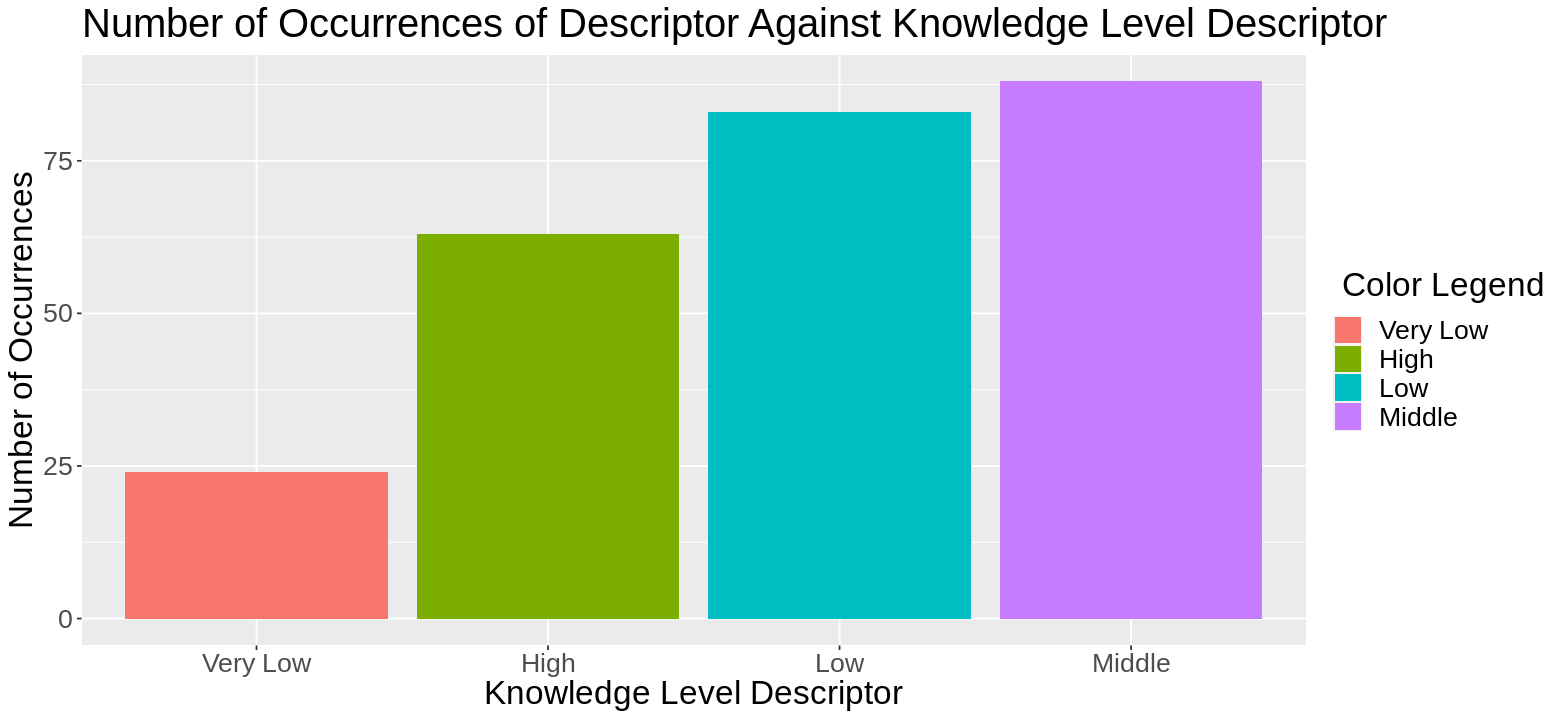

In [48]:
options(repr.plot.width = 13, repr.plot.height = 6)
distribution_of_descriptors_plot <- 
  ggplot(number_of_each_descriptor, aes(x = fct_reorder(direct_knowledge_level, n), y = n, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Number of Occurrences of Descriptor Against Knowledge Level Descriptor") +
  labs(x = "Knowledge Level Descriptor", y = "Number of Occurrences", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_descriptors_plot

This visualization shows clearly the gap in number of occurrences of each descriptor from the table: "Number of each label in direct knowledge level". As stated, this imbalance may lower accuracy during k-nn classification analysis.

#### Distribution of means with knowledge level

Note: for all graphs below, bars are ordered by increasing means

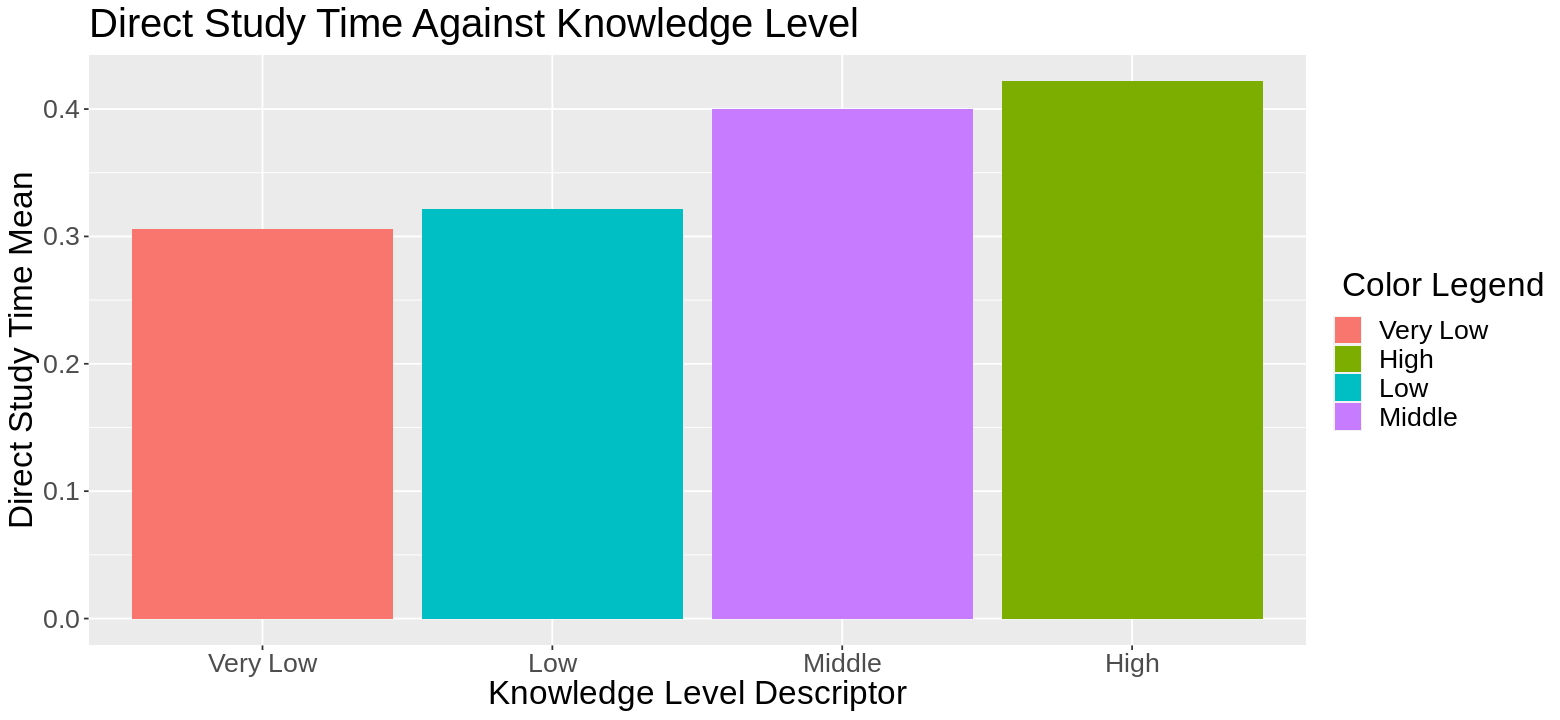

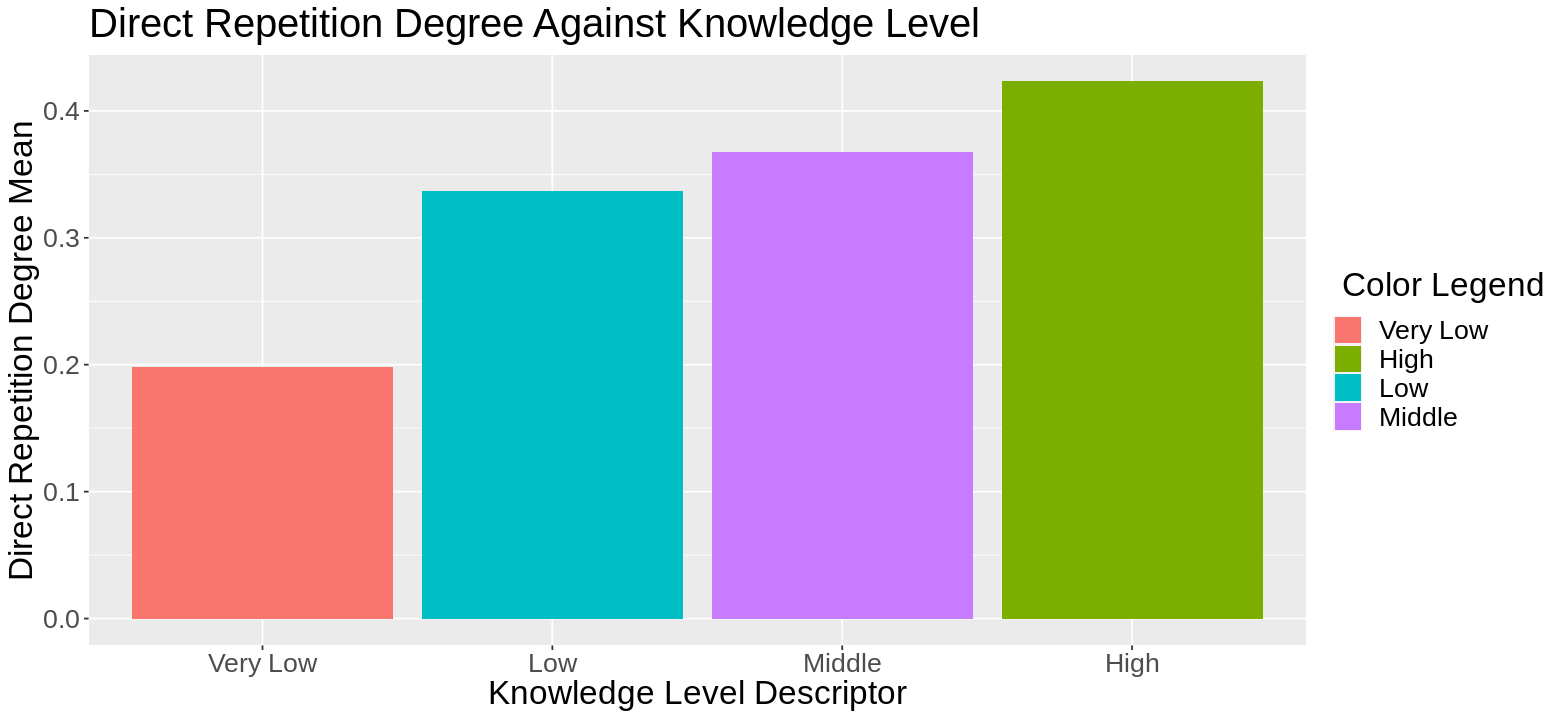

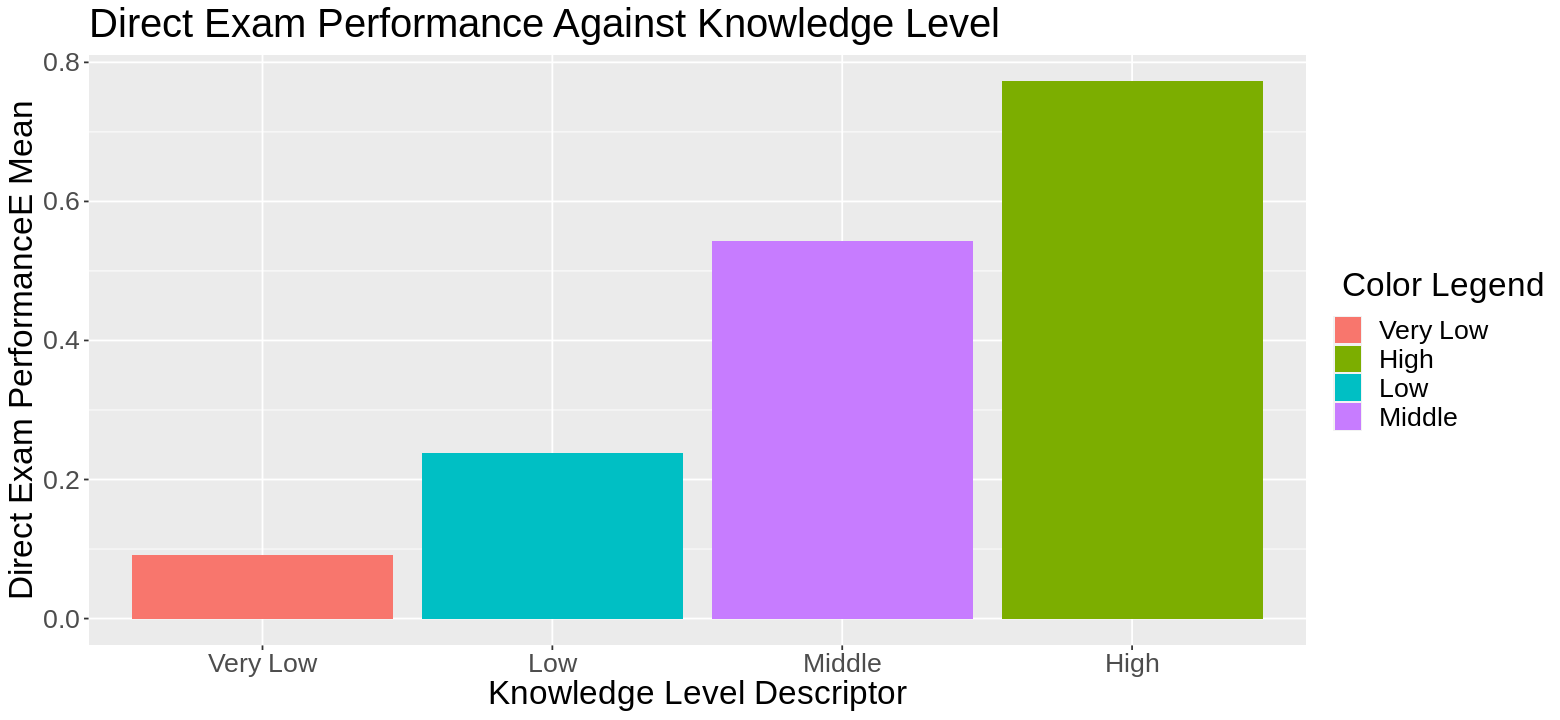

In [49]:
distribution_of_study_time_plot <-
  ggplot(mean_with_grouping, aes(x = fct_reorder(direct_knowledge_level, direct_study_time), y = direct_study_time, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Direct Study Time Against Knowledge Level") +
  labs(x = "Knowledge Level Descriptor", y = "Direct Study Time Mean", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_study_time_plot

distribution_of_repetition_plot <-
  ggplot(mean_with_grouping, aes(x = fct_reorder(direct_knowledge_level, direct_repetition_degree), y = direct_repetition_degree, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Direct Repetition Degree Against Knowledge Level") +
  labs(x = "Knowledge Level Descriptor", y = "Direct Repetition Degree Mean", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_repetition_plot

distribution_of_exam_performance_plot <-
  ggplot(mean_with_grouping, aes(x = fct_reorder(direct_knowledge_level, direct_exam_performance), y = direct_exam_performance, fill = direct_knowledge_level)) +
  geom_bar(stat = "identity") + 
  ggtitle("Direct Exam Performance Against Knowledge Level") +
  labs(x = "Knowledge Level Descriptor", y = "Direct Exam PerformanceE Mean", fill = " Color Legend") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")
distribution_of_exam_performance_plot

From these visualizations, we can see more clearly the correlations of the columns which had positive correlation with higher knowledge levels with higher knowledge levels. These are also the columns that we will use for our first classification. These visualizations effectively shows us the strength of each correlation from the table: "Mean of each numerical column when grouped by knowledge level".

#### Data analysis
We will attempt to use the columns direct exam performances, direct repetition degree, and direct study time to calssify knowledge level using the k-nearest neighbours method.

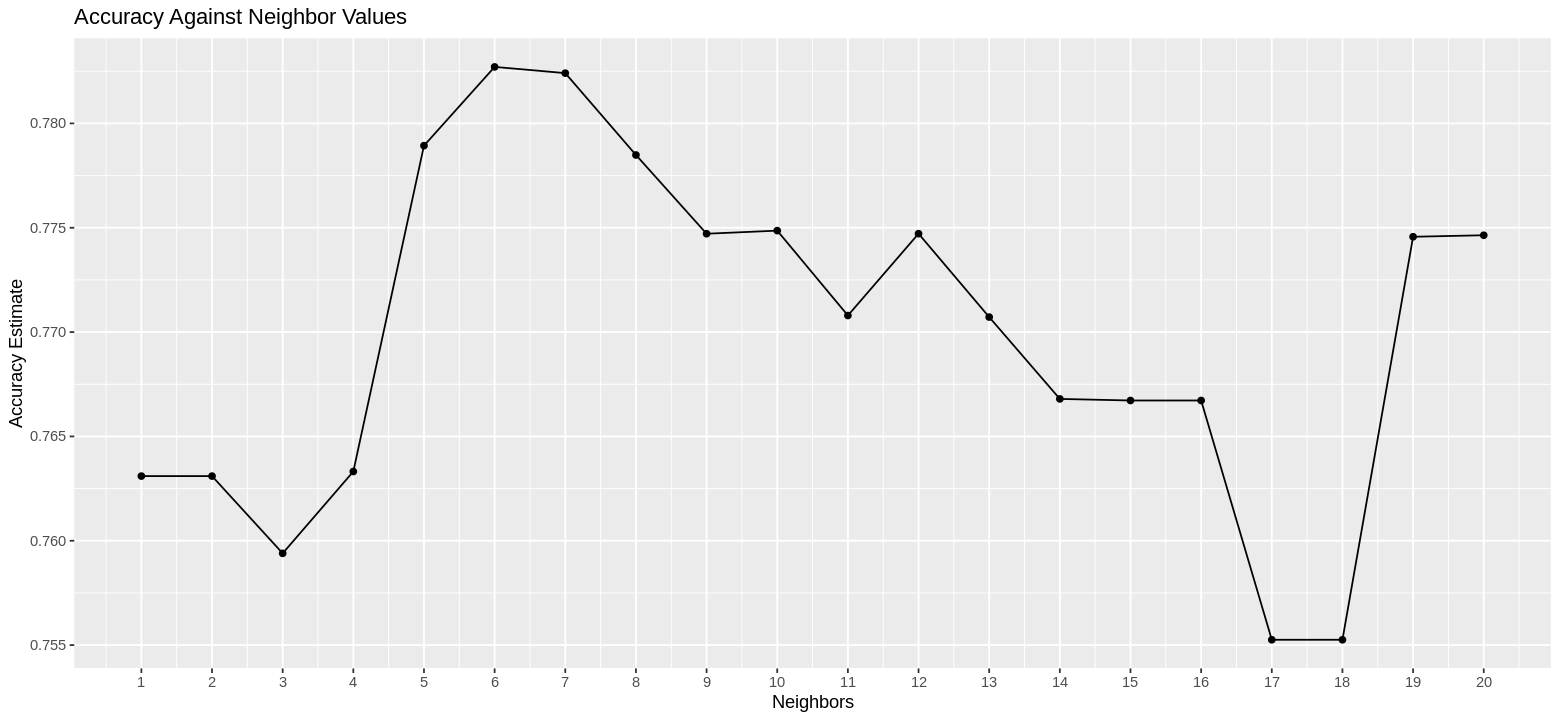

In [50]:
# First, we need to find the best value of k for our k-nn classification analysis. 
# We set the seed to make our study reporductible, then create the recipe which 
# specifies what value we would like to classify and what values we will use for 
# our classification. 
set.seed(123)

recipe_1 <- recipe(direct_knowledge_level ~ direct_study_time + direct_repetition_degree + direct_exam_performance, data = training_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# We then create the specification to specify the k-nn method for classification,
# and also that we are tuning to find the most accurate value for k
knn_tune_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# To make our calculation for accuracy closer to its true value, we use vfold 
# to make split our data into 5 folds. We will also test our k values from 1 to 20.
vfold_1 <- vfold_cv(training_data , v = 5, strata = direct_knowledge_level)

k_values_1 <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

# The code below finds the accuracy with each k, and displays a visualization 
# to show the accuracies for each respective k value.
knn_tune_results <- workflow() |>
       add_recipe(recipe_1) |>
       add_model(knn_tune_1) |>
       tune_grid(resamples = vfold_1, grid = k_values_1) |>
       collect_metrics() |>
       filter(.metric == "accuracy")

accuracies <- knn_tune_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Against Neighbor Values")

accuracy_versus_k

As we can see, the more accurate value of k is 6. 

In [51]:
accuracy_1 <- accuracies %>%
  filter(neighbors == 6) %>%
  select(neighbors, mean)

accuracy_1

neighbors,mean
<dbl>,<dbl>
6,0.7827072


The code above shows us that the accuracy of our classification with the training data  with a k value of 6 is around 78%. Next, lets create our model with a k value of 6.

In [52]:
# This new specification specified the same as before, but now with a k value of 6.
knn_spec_1 <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
  set_engine("kknn") |>
  set_mode("classification")

# Our model is created with the code below with our recipe and our new specification.
fit_training <- workflow() |>
       add_recipe(recipe_1) |>
       add_model(knn_spec_1) |>
       fit(data = training_data)

# The code below applies our model to the testing data and calculates the accuracy of our model when used with the
# testing data.
test_predictions <- predict(fit_training, testing_data) %>%
  bind_cols(testing_data) %>%
  mutate(.pred_class = as_factor(.pred_class)) %>%
  mutate(direct_knowledge_level = as_factor(direct_knowledge_level))

test_predictions$.pred_class <- factor(test_predictions$.pred_class, levels = c("Very Low", "Low", "High", "Middle"))
# The code above reorders the factor levels in .pred_class column to match the factor levels in direct_knowledge_level.
# This step is required for the metrics() function used below. The idea for this code was gotten from stack overflow:
# https://stackoverflow.com/questions/18413756/re-ordering-factor-levels-in-data-frame

prediction_accuracy <- test_predictions |>
  metrics(truth = direct_knowledge_level, estimate = .pred_class) |>
  filter(.metric == "accuracy")

prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7724138


We calculated an accuracy of our model with the testing data of around 77% using the classifiers direct study time, direct repetition degree, and direct exam performance. However, let's try to find the proven more accurate classifiers. We will use the forward selection method to do this. First, it calculates the best single classifier to use, also outputting its accuracy. Then, it calculates the best second classifier (with highest accuracy) to use also showing the accuracy. It does this until all the classifiers are used, showing the accuracy at each step. Then, we can choose the most accurate combination of classifiers.

In [53]:
# The code below was inspired by the forward selection section in the textbook:
# https://datasciencebook.ca/classification2.html
set.seed(123)

subset <- training_data |> 
  select(direct_study_time	, 
         direct_repetition_degree, 
         related_study_time, 
         related_exam_performance, 
         direct_exam_performance, 
         direct_knowledge_level)

names <- colnames(subset |> select(-direct_knowledge_level))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
vfold <- vfold_cv(subset, v = 5, strata = direct_knowledge_level)

# store the total number of predictors
n_total <- 5

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("direct_knowledge_level", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        recipe <- recipe(as.formula(model_string), 
                                data = subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,direct_knowledge_level ~ direct_exam_performance,0.8413828
2,direct_knowledge_level ~ direct_exam_performance+related_exam_performance,0.9534634
3,direct_knowledge_level ~ direct_exam_performance+related_exam_performance+direct_repetition_degree,0.9377017
4,direct_knowledge_level ~ direct_exam_performance+related_exam_performance+direct_repetition_degree+direct_study_time,0.8879109
5,direct_knowledge_level ~ direct_exam_performance+related_exam_performance+direct_repetition_degree+direct_study_time+related_study_time,0.7828552


Lets visualize our results with a bar graph:

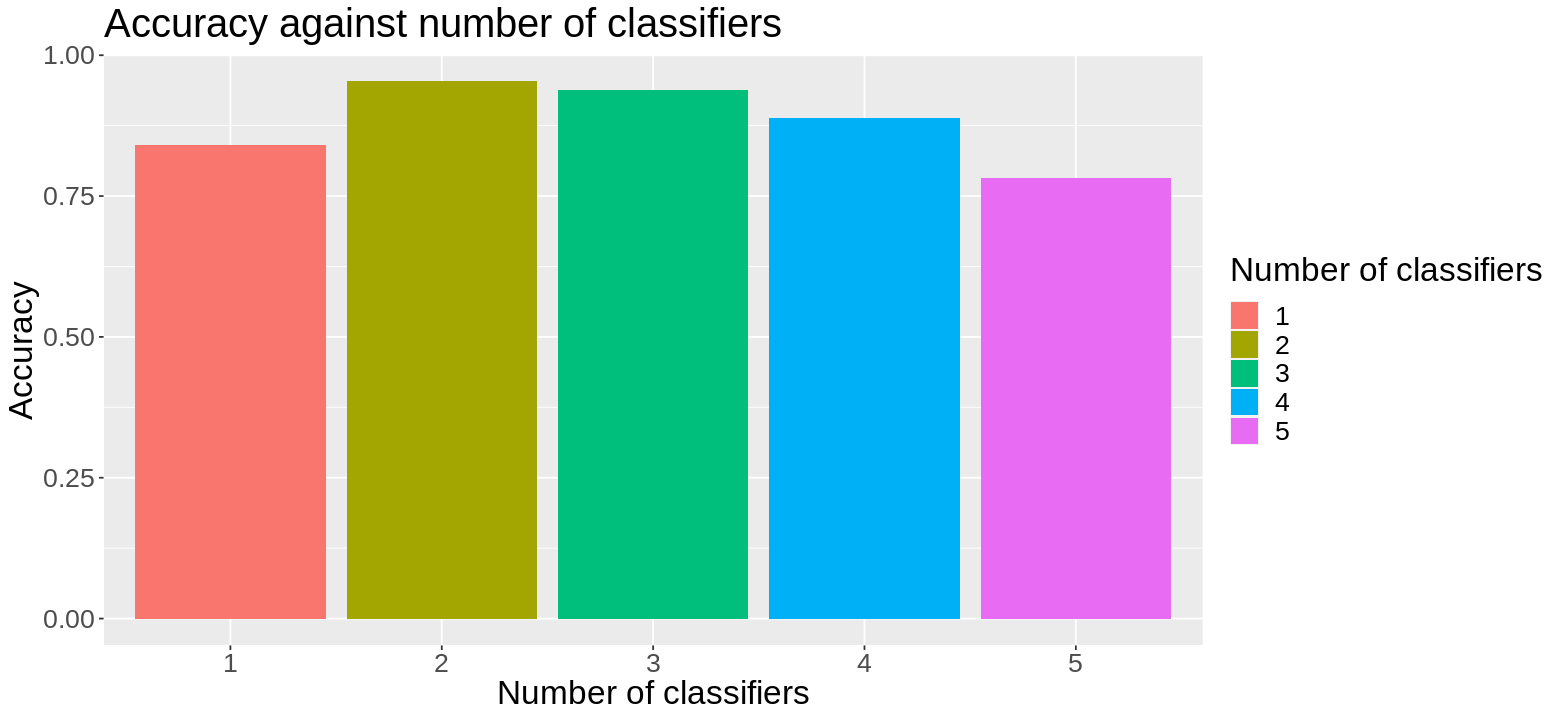

In [54]:
accuracies %>%
  mutate(size = as_factor(size)) %>%
  ggplot(aes(x = size, y = accuracy, fill = size)) +
  geom_bar(stat = "identity") +
  ggtitle("Accuracy against number of classifiers") +
  labs(x = "Number of classifiers", y = "Accuracy", fill = "Number of classifiers") +
  theme(text = element_text(size = 20))  +
  scale_color_brewer(palette = "Set2")

As we can see from our table and graph, our highest accuracy of around 95% is achieved when we use the two classifiers, direct exam performance and related exam performance. Next, lets make our classification with these new classifiers, following the steps from before exactly.

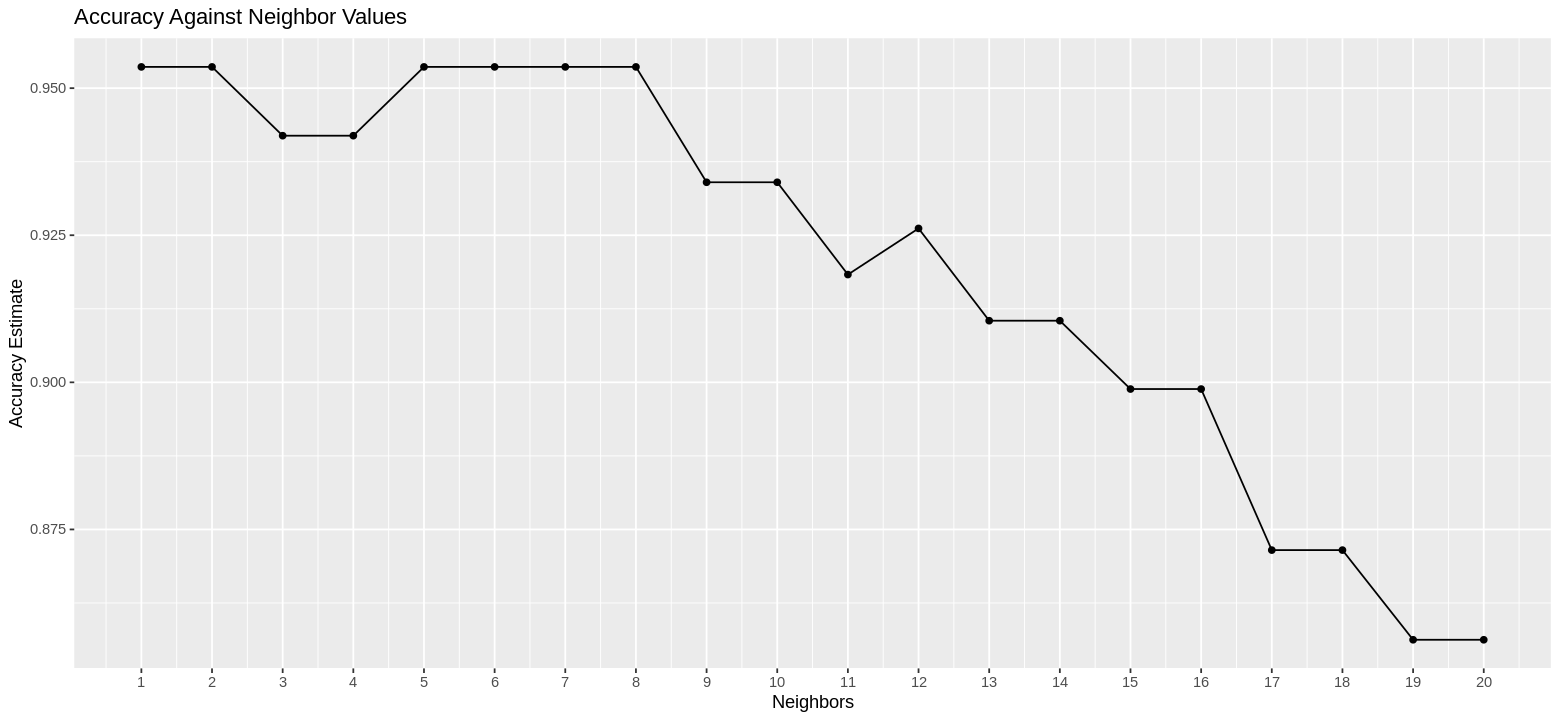

In [55]:
set.seed(123)

recipe_final <- recipe(direct_knowledge_level ~ related_exam_performance + direct_exam_performance, data = training_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune_final <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

vfold_final <- vfold_cv(training_data , v = 5, strata = direct_knowledge_level)

k_values_final <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_tune_results_final <- workflow() |>
       add_recipe(recipe_final) |>
       add_model(knn_tune_final) |>
       tune_grid(resamples = vfold_final, grid = k_values_final) |>
       collect_metrics() |>
       filter(.metric == "accuracy")

accuracies_final <- knn_tune_results_final |> 
       filter(.metric == "accuracy")

accuracy_versus_k_final <- ggplot(accuracies_final, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy Against Neighbor Values")

accuracy_versus_k_final

Our best values for k are 1, 2, 5, 6, 7, or 8,as they all have the same highest accuracy. We arbitrarily choose 8 as our k value.

In [56]:
accuracy_final <- accuracies_final %>%
  filter(neighbors == 8) %>%
  select(neighbors, mean)

accuracy_final

neighbors,mean
<dbl>,<dbl>
8,0.9536114


Our accuracy with 8 neighbors is around 95%. Now, we create the model and test it with the testing data.

In [57]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
  set_engine("kknn") |>
  set_mode("classification")

fit_training <- workflow() |>
       add_recipe(recipe_final) |>
       add_model(knn_spec_final) |>
       fit(data = training_data)

test_predictions_final <- predict(fit_training, testing_data) %>%
  bind_cols(testing_data) %>%
  mutate(.pred_class = as_factor(.pred_class)) %>%
  mutate(direct_knowledge_level = as_factor(direct_knowledge_level))

test_predictions_final$.pred_class <- factor(test_predictions_final$.pred_class, levels = c("Very Low", "Low", "High", "Middle"))
# The code above reorders the factor levels in .pred_class column to match the factor levels in direct_knowledge_level.
# This step is required for the metrics() function used below. The idea for this code was gotten from stack overflow:
# https://stackoverflow.com/questions/18413756/re-ordering-factor-levels-in-data-frame

prediction_accuracy_final <- test_predictions_final |>
  metrics(truth = direct_knowledge_level, estimate = .pred_class) |>
  filter(.metric == "accuracy")

prediction_accuracy_final

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9586207


Our accuracy tested with testing data when using the classifiers direct exam results and related exam results with a 8 neighbors using k-nn classification is 96%. This accuracy is quite satisfactory, as we can predict a random student's knowledge level quite accurately. With the new classifiers, have also improve our accuracy drastically, from 77% to 96%. To achieve our findings, we used many visualization, such as graphs showing the best value for k, and a graph to show accuracies for each classifier combination.

## Discussion

### Findings:
We have found that the best variables used for classifying a student's knowledge level is through their exam results of both the subject itself and related subjects. Furthermore, we found that our hypothesis of the best classifiers as being direct exam results, direct repetition degree, and direct study time proved to by much less accurate in k-nn classification. This shows that our intuition on choosing the best parameters for classifying a student's knowledge level was misguided.

### Impact of our findings:
In this study and through our specific dataset, our findings show that test results, both for the subject and related to the subject, are the best ways to determine a student's knowledge level. In fact, they measure a student's knowledge level better than the student's time spent on studying, and how much repetition they use in studying. This may show that tests are indeed important in showing a student's understanding on a subject. It also shows that exam results not of the subject, but just related to the subject can greatly help show a student's understanding. However, we propose that more studies on different data sets are needed for more conclusive evidence on what really shows a students understanding, as we have only used one dataset collected in a certain way.

One study concluded that "incorporating opportunities for retrieval after teaching is an essential component of lasting learning" (Yang BW), which supports our results. Testing may be an important way of solidifying a student's knowledge, and in turn also shows how understanding they are of the subject. 

In contrast, another article claims that "Exams themselves only take a number of factors into account, and sometimes intelligent students who cannot cope with the pressures of exams fail to achieve their full potential after getting poor grades." (Ed Blog) Although our results show that exam results are indeed a good measure of knowledge, it can not be ignored that there are many factors other than knowledge that determine a student's exam results. 

#### Future questions:
1.What other variables may affect user knoweldge? 

2.Are there more important variables than the ones we have?

### Citations
    Yang BW, Razo J, Persky AM. Using Testing as a Learning Tool. Am J Pharm Educ. 2019 Nov;83(9):7324. doi: 10.5688/ajpe7324. PMID: 31871352; PMCID: PMC6920642.
    
    Ed Blog. “Exam Results - Are They an Accurate Measure of Achievement?” EDBlog, 19 July 2017, https://blog.edclass.com/exam-results-are-they-an-accurate-measure-of-achievement/. 